# TODO


- [ ] change pflip(p, var) to pflip(var, p)
- [x] `expectation` operator
- [ ] enumerate 4.5 mins for medical+hospital example
- [ ] physics simulation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc
from pyro import poutine
pyro.enable_validation()

import functools
import uuid

from pmc_webppl import flip, pflip, repeat, memoize, factor, cond_var, condition, expectation, Infer, viz

# Hypothetical Reasoning with Infer

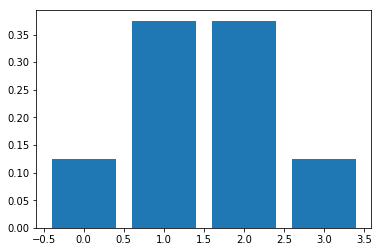

In [2]:
def model():
    A = pflip('A', 0.5)
    B = pflip('B', 0.5)
    C = pflip('C', 0.5)
    return A + B + C

# make the marginal distributions on return values explicit
d = Infer(model, posterior_method='enumerate')
viz(d)

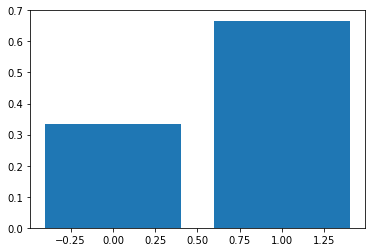

In [3]:
def model():
    A = pflip('A', 0.5)
    B = pflip('B', 0.5)
    C = pflip('C', 0.5)
    D = pyro.sample('D', dist.Normal(A + B + C, 1e-15))
    return A

conditioned_model = pyro.condition(model, data={'D': torch.tensor(2)})

d = Infer(conditioned_model, posterior_method='enumerate')
viz(d)

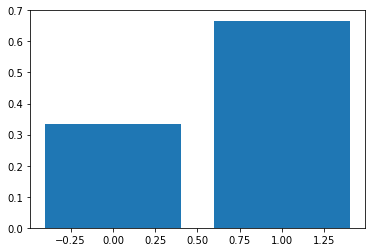

In [4]:
def conditioned_model2():
    A = pflip('A', 0.5)
    B = pflip('B', 0.5)
    C = pflip('C', 0.5)
    D = pyro.sample('D', dist.Normal(A + B + C, 1e-15), obs=torch.tensor(2))
    return A

d = Infer(conditioned_model2, posterior_method='enumerate')
viz(d)

# Rejection sampling

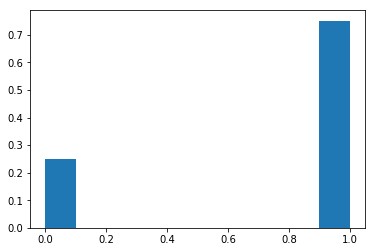

In [5]:
def conditioned_model_sample():
    A = flip(0.5)
    B = flip(0.5)
    C = flip(0.5)
    D = A + B + C
    if D >= 2:
        return A
    return conditioned_model_sample()

viz(repeat(conditioned_model_sample, 1000))

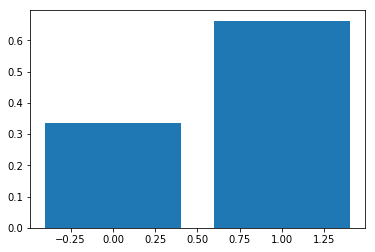

In [6]:
viz(Infer(conditioned_model, posterior_method='rejection'))

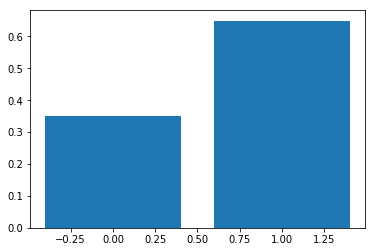

In [7]:
viz(Infer(conditioned_model2, posterior_method='rejection'))

# Posterior Inference

/Users/big/lib/pyro/tutorial/source/PMC/pmc_webppl.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pyro.sample(name, dist.Normal(torch.tensor(var), torch.tensor(normal_std)),


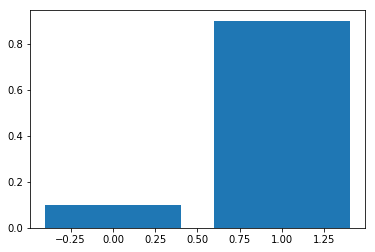

In [8]:
observed_data = True
prior = lambda: pflip('prior', 0.5)
likelihood = lambda h: (pflip('h', 0.9) if h else pflip('h', 0.1))

def model():
    hypothesis = prior()
    data = likelihood(hypothesis)
#     pyro.sample('cond', dist.Normal(data, 1e-15), obs=torch.tensor(observed_data))
    condition('cond', data, observed_data)
    return hypothesis

posterior = Infer(model)
viz(posterior)

# Conditions and observations

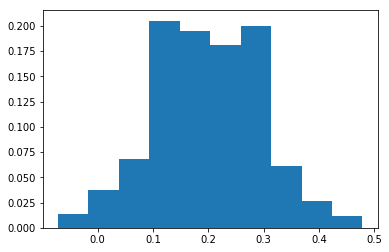

In [9]:
def conditioned_model():
    true_x = dist.Normal(0, 1).sample()      #pyro.sample('true_x', dist.Normal(0, 1))
    pyro.sample('obs_x', dist.Normal(true_x, 0.1), obs=torch.tensor(0.2))
    return true_x

viz(Infer(conditioned_model, posterior_method='forward', draw_samples=True))

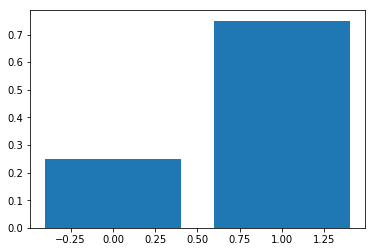

In [10]:
def model():
    A = pflip('A', 0.5)
    B = pflip('B', 0.5)
    C = pflip('C', 0.5)
    D = int(A + B + C >= 2)
    pyro.sample('D', dist.Normal(D, 1e-15))
    return A

conditioned_model = pyro.condition(model, data={'D': torch.tensor(2)})

d = Infer(conditioned_model, posterior_method='enumerate')
viz(d)

# Factors

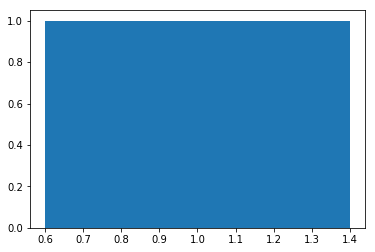

In [11]:
def model():
    A = flip()
    factor('B', (0 if A else -99999))
    return A

d = Infer(model, num_samples=int(1e4))
viz(d)

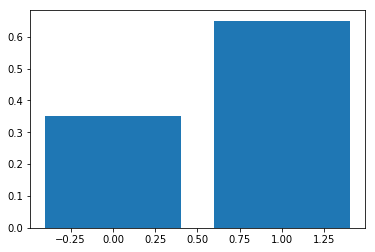

In [12]:
def model():
    A = pflip('A', 0.5)
    factor('B', (0 if A else -1))
    return A

d = Infer(model, num_samples=int(1e4))
viz(d)

# Example: Reasoning About Tug of War

In [13]:
@memoize
def strength(person):
    return abs(dist.Normal(1, 1).sample())

def lazy(person):
    return flip(1 / 3.)

def pulling(person):
    return (strength(person) / 2 if lazy(person) else strength(person))

def total_pulling(team):
    return sum(map(pulling, team))

def winner(team1, team2):
    return team1 if (total_pulling(team1) > total_pulling(team2)) else team2

[
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'tom'], ['bob', 'sue']),
    winner(['alice', 'tom'], ['bob', 'sue'])
]

[['alice', 'bob'],
 ['alice', 'bob'],
 ['alice', 'sue'],
 ['alice', 'sue'],
 ['alice', 'tom'],
 ['alice', 'tom']]


Expected strength: 1.5148286819458008


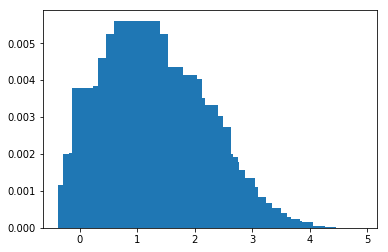

In [14]:
def model():
    
    @memoize
    def strength(person):
        return pyro.sample(f'strength_{person}', dist.Normal(1, 1)).abs()

    def lazy(person): 
        return flip(1 / 3.)
    
    def pulling(person): 
        return strength(person) / 2 if lazy(person) else strength(person)
    
    def total_pulling(team): 
        return sum(map(pulling, team))
    
    def winner(team1, team2): 
        return team1 if (total_pulling(team1) > total_pulling(team2)) else team2 
    
    def beat(team1, team2): 
        return winner(team1, team2) == team1

    condition('beats_1', beat(['bob', 'mary'], ['tom', 'sue']))
    condition('beats_2', beat(['bob', 'sue'],  ['tom', 'jim']))
    return strength('bob')

# d = Infer(model, posterior_method='MCMC', num_samples=1000)
d = Infer(model, posterior_method='rejection', num_samples=1000)

print('Expected strength: {}'.format(d.mean))
viz(d)#, plot_args={'bins': 30})


Expectation of first team winning: 0.921


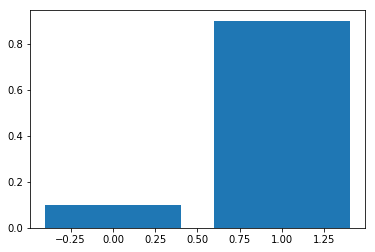

In [15]:
def model():

    @memoize
    def strength(person):
        return pyro.sample(f'strength_{person}', dist.Normal(1, 1)).abs()

    def lazy(person): 
        return flip(1 / 3.)
    
    def pulling(person): 
        return strength(person) / 2 if lazy(person) else strength(person)
    
    def total_pulling(team): 
        return sum(map(pulling, team))
    
    def winner(team1, team2): 
        return team1 if (total_pulling(team1) > total_pulling(team2)) else team2 
    
    def beat(team1, team2): 
        return torch.tensor(winner(team1, team2) == team1, dtype=torch.int)

    condition('stronger', strength('mary') >= strength('sue'))
    condition('beats', beat(['bob'], ['jim']))
    return beat(['bob', 'mary'], ['jim', 'sue'])


d = Infer(model, posterior_method='rejection', num_samples=1000)


support = d.enumerate_support().tolist()
m = sum(support) / len(support)

print('Expectation of first team winning: {}'.format(m))
viz(d)

hidden: doing these jointly in a single model with pyro.condition. there must be a better way to do this.

<!--
def model():
    
    @memoize
    def strength(person):
        return pyro.sample(f'strength_{person}', dist.Normal(1, 1)).abs()

    def lazy(person): 
        return flip(1 / 3.)
    
    def pulling(person): 
        return strength(person) / 2 if lazy(person) else strength(person)
    
    def total_pulling(team): 
        return sum(map(pulling, team))
    
    def winner(team1, team2): 
        return team1 if (total_pulling(team1) > total_pulling(team2)) else team2 
    
    def beat(team1, team2): 
        return torch.tensor(winner(team1, team2) == team1, dtype=torch.float)  #winner(team1, team2) == team1

    cond_var('beats_1', beat(['bob', 'mary'], ['tom', 'sue']))
    cond_var('beats_2', beat(['bob', 'sue'],  ['tom', 'jim']))
    cond_var('stronger', torch.tensor(strength('mary') >= strength('sue'), dtype=torch.float))
    cond_var('beats', beat(['bob'], ['jim']))
    
    return strength('bob'), beat(['bob', 'mary'], ['jim', 'sue'])


conditioned_model = pyro.condition(lambda: model()[0], 
                                   data={'beats_1': torch.tensor(1), 
                                         'beats_2': torch.tensor(1)})
d = Infer(conditioned_model, posterior_method='rejection', num_samples=1000)
print('Expected strength: {}'.format(d.mean))
viz(d, plot_args={'bins': 30})


conditioned_model = pyro.condition(lambda: model()[1], 
                                   data={'stronger': torch.tensor(1), 
                                         'beats': torch.tensor(1)})
d = Infer(conditioned_model, posterior_method='rejection', num_samples=1000)
viz(d, plot_args={'bins': 30})

-->

# Example: Causal Inference in Medical Diagnosis

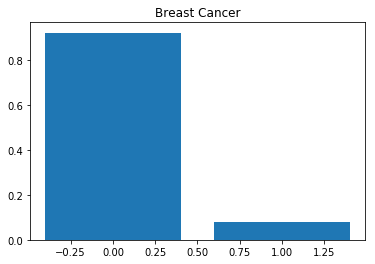

In [25]:
def model():
    breast_cancer = pflip('breast_cancer', 0.01)
    pm_prob = 0.8 if breast_cancer else 0.096
    positive_mammogram = pflip('positive_mammogram', pm_prob)
    condition('p', positive_mammogram)
    return breast_cancer
   
d = Infer(model, posterior_method='enumerate', num_samples=1000)
viz(d, title='Breast Cancer')

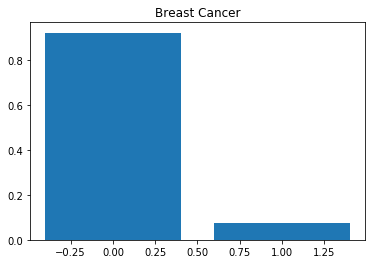

In [26]:
def model():
    breast_cancer = pflip('breast_cancer', 0.01)
    benign_cyst = pflip('benign_cyst', 0.2)
    pm_prob = ((breast_cancer and pflip('bc2', 0.8)) or 
               (benign_cyst and pflip('bc1', 0.5)))
    
    positive_mammogram = pflip('positive_mammogram', pm_prob)
    condition('p', positive_mammogram)
    return breast_cancer
   
d = Infer(model, posterior_method='enumerate', num_samples=1000)
viz(d, title='Breast Cancer')

In [18]:
def model():
    lung_cancer = pflip('lung_cancer', 0.01)
    tb = pflip('tb', 0.005)
    cold = pflip('cold', 0.2)
    stomach_flu = pflip('stomach_flu', 0.1)
    other = pflip('other', 0.1)

    cough = ((cold and pflip('cold-cough', 0.5)) or
             (lung_cancer and pflip('lung_cancer-cough', 0.3)) or
             (tb and pflip('tb-cough', 0.7)) or
             (other and pflip('other-cough', 0.01)))

    fever = ((cold and pflip('cold-fever', 0.3)) or
             (stomach_flu and pflip('stomach_flu-fever', 0.5)) or
             (tb and pflip('tb-fever', 0.2)) or
             (other and pflip('other-fever', 0.01)))

    chest_pain = ((lung_cancer and pflip('lung_cancer-chest_pain', 0.4)) or
                  (tb and pflip('tb-chest_pain', 0.5)) or
                  (other and pflip('other-chest_pain', 0.01)))

    shortness_of_breath = ((lung_cancer and pflip('lung_cancer-breath', 0.4)) or
                           (tb and pflip('tb-breath', 0.5)) or
                           (other and pflip('other-breath', 0.01)))

    condition('symptoms', cough and fever and chest_pain and shortness_of_breath)
    return lung_cancer, tb

d_cancer = Infer(lambda: model()[0], posterior_method='enumerate', num_samples=1000)
d_tb = Infer(lambda: model()[1], posterior_method='enumerate', num_samples=1000)

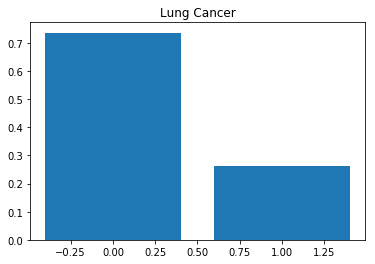

In [19]:
viz(d_cancer, title='Lung Cancer')

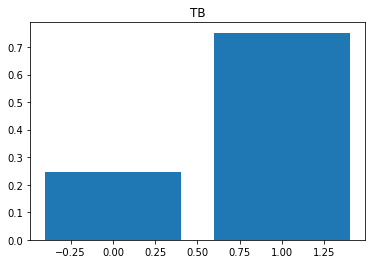

In [20]:
viz(d_tb, title='TB')

In [13]:
def model():
    works_in_hospital = pflip('hospital', 0.01)
    smokes = pflip('smokes', 0.2)
    
    lung_cancer = (pflip('lung_cancer', 0.01) or 
                   (smokes and pflip('hospital-lung_cancer', 0.01)))
    tb = (pflip('tb', 0.005) or 
          (works_in_hospital and pflip('hospital-tb', 0.01)))
    cold = (pflip('cold', 0.2) or 
            (works_in_hospital and pflip('hospital-cold', 0.25)))
    stomach_flu = pflip('stomach_flu', 0.1)
    other = pflip('other', 0.1)

    cough = ((cold and pflip('cold-cough', 0.5)) or
             (lung_cancer and pflip('lung_cancer-cough', 0.3)) or
             (tb and pflip('tb-cough', 0.7)) or
             (other and pflip('other-cough', 0.01)))

    fever = ((cold and pflip('cold-fever', 0.3)) or
             (stomach_flu and pflip('stomach_flu-fever', 0.5)) or
             (tb and pflip('tb-fever', 0.2)) or
             (other and pflip('other-fever', 0.01)))

    chest_pain = ((lung_cancer and pflip('lung_cancer-chest_pain', 0.4)) or
                  (tb and pflip('tb-chest_pain', 0.5)) or
                  (other and pflip('other-chest_pain', 0.01)))

    shortness_of_breath = ((lung_cancer and pflip('lung_cancer-breath', 0.4)) or
                           (tb and pflip('tb-breath', 0.5)) or
                           (other and pflip('other-breath', 0.01)))


    condition('symptoms', cough and chest_pain and shortness_of_breath)
    return lung_cancer, tb


d_cancer = Infer(lambda: model()[0], posterior_method='enumerate', num_samples=1000)
d_tb = Infer(lambda: model()[1], posterior_method='enumerate', num_samples=1000)

/Users/big/lib/pyro/env/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


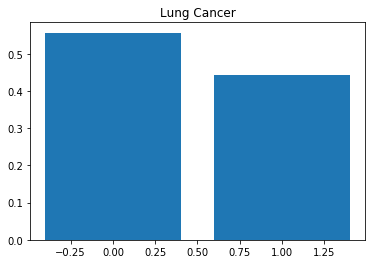

In [14]:
viz(d_cancer, title='Lung Cancer')

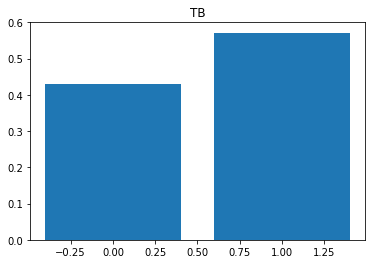

In [15]:
viz(d_tb, title='TB')

# Example: Inverse intuitive physics

In [3]:
import sys
sys.path.append('/Users/big/lib/PyroBPL/env/lib/python3.7/site-packages')
import pymunk

Loading chipmunk for Darwin (64bit) [/Users/big/lib/PyroBPL/env/lib/python3.7/site-packages/pymunk/libchipmunk.dylib]


In [ ]:
# makes a floor with evenly spaced buckets
def bins(xmin, xmax, width):
    if (xmax < xmin + width):  # floor
        return {'shape': 'rect', 'static': true, 'dims': [400, 10], 'x': 175, 'y': 500}
    return [{'shape': 'rect', 'static': true, dims: [1, 10], x: xmin, y: 490}] \
            .concat(bins(xmin + width, xmax, width))   # bins

# add two fixed circles
world = [
    {shape: 'circle', static: true, dims: [60], x: 60, y: 200},
    {shape: 'circle', static: true, dims: [30], x: 300, y: 300}
].concat(bins(-1000, 1000, 25))

randomBlock = function () {
  return {shape: 'circle', static: false, dims: [10], x: uniform(0, worldWidth), y: 0}
}


In [ ]:
# makes a floor with evenly spaced buckets
def bins(xmin, xmax, width):
    if (xmax < xmin + width):  # floor
        return {'shape': 'rect', 'static': true, 'dims': [400, 10], 'x': 175, 'y': 500}
    return [{'shape': 'rect', 'static': true, dims: [1, 10], x: xmin, y: 490}] \
            .concat(bins(xmin + width, xmax, width))   # bins

# add two fixed circles
world = [
    {shape: 'circle', static: true, dims: [60], x: 60, y: 200},
    {shape: 'circle', static: true, dims: [30], x: 300, y: 300}
].concat(bins(-1000, 1000, 25))

randomBlock = function () {
  return {shape: 'circle', static: false, dims: [10], x: uniform(0, worldWidth), y: 0}
}

getBallX = function(world) {
  ball = filter(function(obj) { return !obj.static }, world)[0];
  return ball.x;
}

observedX = 160;

model = function() {
  initState = world.concat([randomBlock()])
  initX = getBallX(initState);
  finalState = physics.run(1000, initState);
  finalX = getBallX(finalState);
  observe(Gaussian({mu: finalX, sigma: 10}), observedX)
  return {initX: initX}
}

initialXDist = Infer(
  {method: 'MCMC',
   samples: 100,
   lag: 10,
   callbacks: [editor.MCMCProgress()]
  },
  model);

viz.density(initialXDist, {bounds: [0,350]})

In [3]:
%matplotlib inline

In [ ]:
### Physics stuff
space = pm.Space()
space.gravity = (0.0, -1900.0)
space.damping = 0.999 # to prevent it from blowing up.
mouse_body = pm.Body(body_type=pm.Body.KINEMATIC)

bodies = []
for x in range(-100,150,50):
    x += width / 2
    offset_y = height/2
    mass = 10
    radius = 25
    moment = pm.moment_for_circle(mass, 0, radius, (0,0))
    body = pm.Body(mass, moment)
    body.position = (x,-125+offset_y)
    body.start_position = Vec2d(body.position)
    shape = pm.Circle(body, radius)
    shape.elasticity = 0.9999999
    space.add(body, shape)
    bodies.append(body)
    pj = pm.PinJoint(space.static_body, body, (x,125+offset_y), (0,0))
    space.add(pj)
    
while True: 
    space.step(1/50.0) #3

In [8]:
def add_ball(space, x, y, radius=14, mass=1):
    # Add a ball to the given space.
    inertia = pymunk.moment_for_circle(mass, 0, radius, (0,0))
    body = pymunk.Body(mass, inertia)
    body.position = x, y
    shape = pymunk.Circle(body, radius, (0,0))
    space.add(body, shape)
    return shape

In [7]:
import sys
import pygame
from pygame.locals import *
import pymunk as pm #1

space = pm.Space()
space.gravity = (0.0, -900.0)



for i in range(100):
    space.step(1/50.0)
    print(space.__dict__)


{'threaded': False, '_space': <cdata 'cpSpace *' 0x7ff6facf7f40>, '_handlers': {}, '_post_step_callbacks': {}, '_removed_shapes': {}, '_shapes': {}, '_bodies': set(), '_static_body': None, '_constraints': set(), '_in_step': False, '_add_later': set(), '_remove_later': set()}
{'threaded': False, '_space': <cdata 'cpSpace *' 0x7ff6facf7f40>, '_handlers': {}, '_post_step_callbacks': {}, '_removed_shapes': {}, '_shapes': {}, '_bodies': set(), '_static_body': None, '_constraints': set(), '_in_step': False, '_add_later': set(), '_remove_later': set()}
{'threaded': False, '_space': <cdata 'cpSpace *' 0x7ff6facf7f40>, '_handlers': {}, '_post_step_callbacks': {}, '_removed_shapes': {}, '_shapes': {}, '_bodies': set(), '_static_body': None, '_constraints': set(), '_in_step': False, '_add_later': set(), '_remove_later': set()}
{'threaded': False, '_space': <cdata 'cpSpace *' 0x7ff6facf7f40>, '_handlers': {}, '_post_step_callbacks': {}, '_removed_shapes': {}, '_shapes': {}, '_bodies': set(), '_sta